# Multivariate Time Series Forecasting

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
#get data

path = './train_2.csv'
df_chunk = pd.read_csv(path, chunksize=10000)

chunk_list = []
for chunk in df_chunk:  
    chunk_list.append(chunk)

df = pd.concat(chunk_list)

# 1. Data Preprocessing

Data includes approx. 145k time series, each of them represents daily visiting number of a different Wikipedia article between 2015-07-01 and 2017-09-10. Each article name has the following format: *'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider')*

In [3]:
def split_pagename_fields(s):
    s_split = s.split('_')
    return '_'.join(s_split[:-3]), *s_split[-3:]

df['Title'], df['Project'], df['Device'], df['Agent'] = list(zip(*df['Page'].map(split_pagename_fields)))
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,Title,Project,Device,Agent
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,16.0,27.0,29.0,23.0,54.0,38.0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,54.0,25.0,26.0,23.0,13.0,81.0,2PM,zh.wikipedia.org,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,7.0,3.0,4.0,7.0,6.0,3C,zh.wikipedia.org,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,6.0,16.0,19.0,30.0,38.0,4.0,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,23.0,28.0,14.0,8.0,7.0,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


In [4]:
for col in ['Project', 'Device', 'Agent']:
    print(df.groupby(col)['Project'].count())
    print()

Project
commons.wikimedia.org    10555
de.wikipedia.org         18547
en.wikipedia.org         24108
es.wikipedia.org         14069
fr.wikipedia.org         17802
ja.wikipedia.org         20431
ru.wikipedia.org         15022
www.mediawiki.org         7300
zh.wikipedia.org         17229
Name: Project, dtype: int64

Device
all-access    74315
desktop       34809
mobile-web    35939
Name: Project, dtype: int64

Agent
all-agents    110150
spider         34913
Name: Project, dtype: int64



This multivariate data set consists of time series for each Wikipedia project. 

In [5]:
df_p = df.groupby('Project').sum().T
df_p.columns.name = None
df_p.index = pd.to_datetime(df_p.index, infer_datetime_format=True)
df_p

,commons.wikimedia.org,de.wikipedia.org,en.wikipedia.org,es.wikipedia.org,fr.wikipedia.org,ja.wikipedia.org,ru.wikipedia.org,www.mediawiki.org,zh.wikipedia.org
2015-07-01,1140821.0,13260519.0,84712190.0,15278553.0,8458638.0,11863200.0,9463854.0,349713.0,4144988.0
2015-07-02,1178130.0,13079896.0,84438545.0,14601013.0,8512952.0,13620792.0,9627643.0,383680.0,4151189.0
2015-07-03,1150547.0,12554042.0,80167728.0,13427632.0,8186030.0,12305383.0,8923463.0,325714.0,4123659.0
2015-07-04,951317.0,11520379.0,83463204.0,12606538.0,8749842.0,15456239.0,8393214.0,308756.0,4163448.0
2015-07-05,1058036.0,13392347.0,86198637.0,13710356.0,8590493.0,14827204.0,8938528.0,338485.0,4441286.0
...,...,...,...,...,...,...,...,...,...
2017-09-06,4700532.0,12373349.0,92862934.0,17410117.0,9222511.0,11695723.0,14971353.0,4123833.0,4993794.0
2017-09-07,10787037.0,14257897.0,97701973.0,16786454.0,9067156.0,12963373.0,10460920.0,3500817.0,5205657.0
2017-09-08,1982500.0,11705679.0,74417827.0,14396083.0,8004593.0,11691175.0,9034957.0,502495.0,5019361.0
2017-09-09,2102161.0,10902535.0,71919663.0,11635387.0,8444916.0,12497823.0,9198499.0,414084.0,5244444.0


In [6]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   commons.wikimedia.org  803 non-null    float64
 1   de.wikipedia.org       803 non-null    float64
 2   en.wikipedia.org       803 non-null    float64
 3   es.wikipedia.org       803 non-null    float64
 4   fr.wikipedia.org       803 non-null    float64
 5   ja.wikipedia.org       803 non-null    float64
 6   ru.wikipedia.org       803 non-null    float64
 7   www.mediawiki.org      803 non-null    float64
 8   zh.wikipedia.org       803 non-null    float64
dtypes: float64(9)
memory usage: 62.7 KB


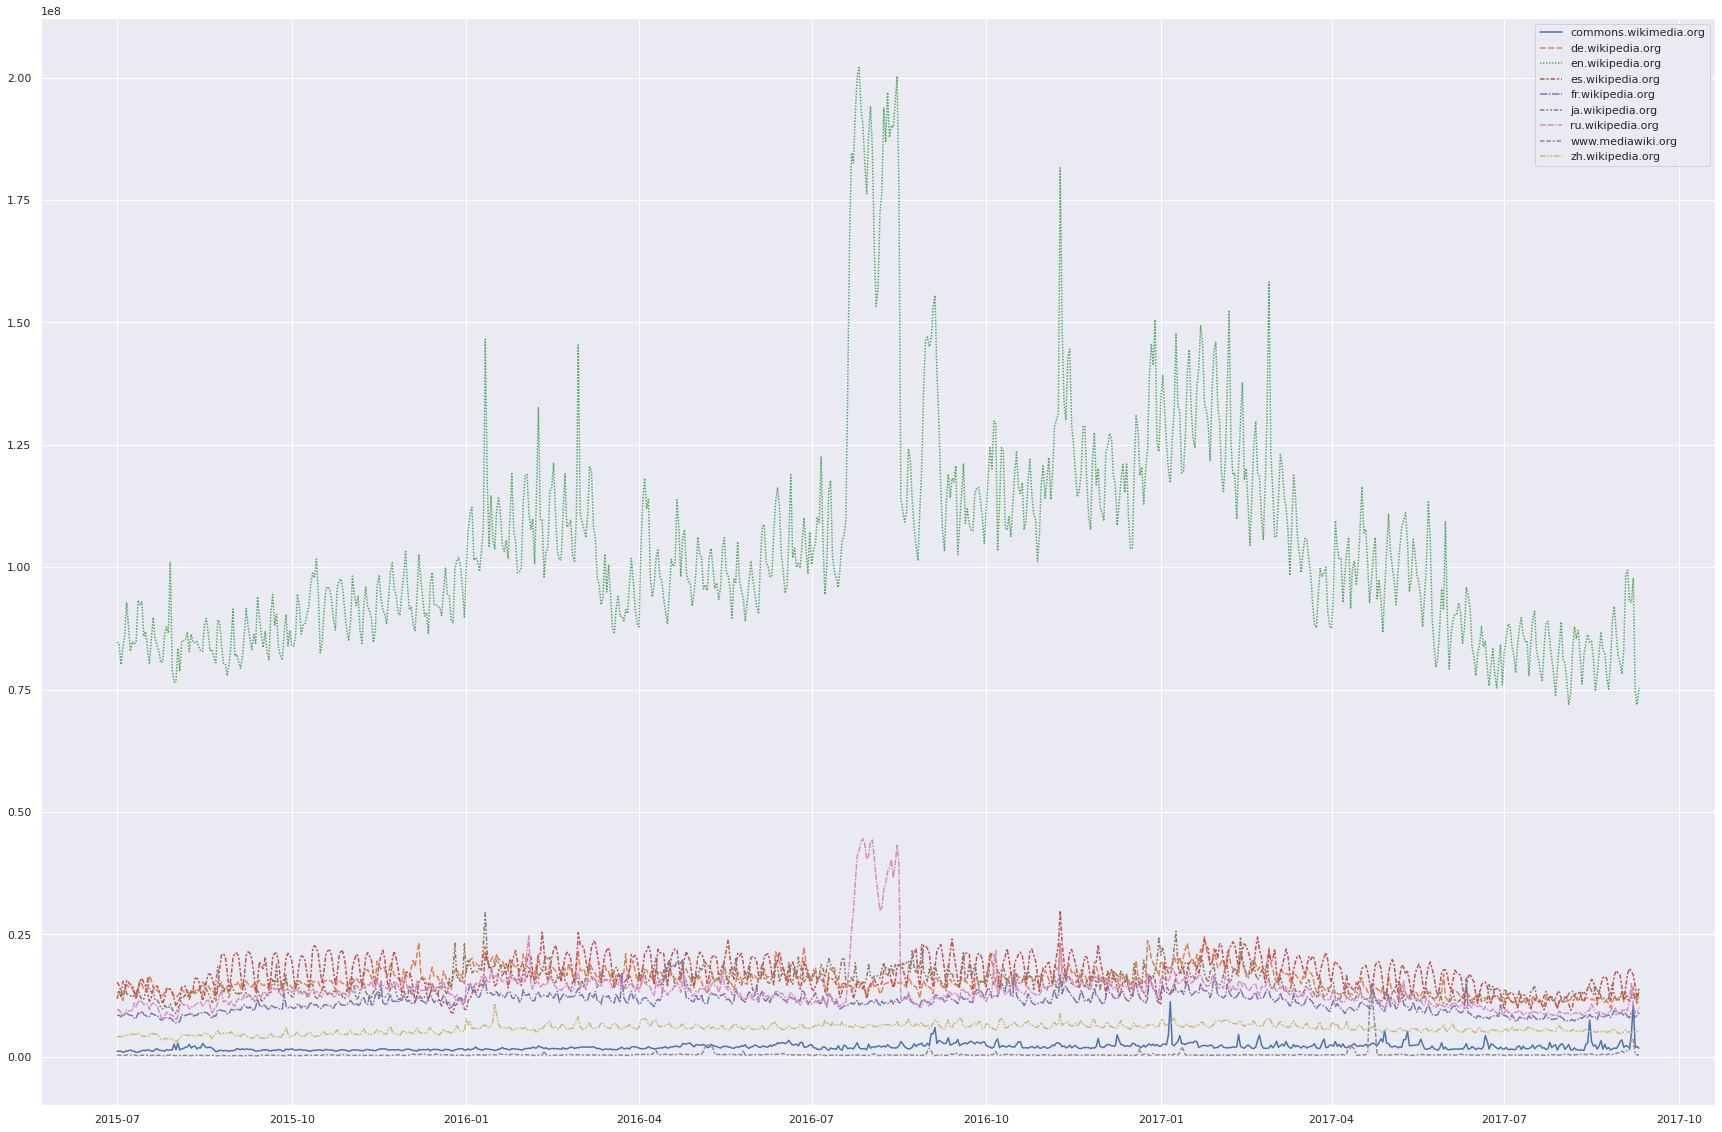

In [7]:
sns.set(rc={'figure.figsize':(30, 20)})

results_ = sns.lineplot(data = df_p)

In [8]:
# normalize time series

for col in df_p.columns:
    df_p[col] = (df_p[col] - df_p[col].min()) / (df_p[col].max() - df_p[col].min())

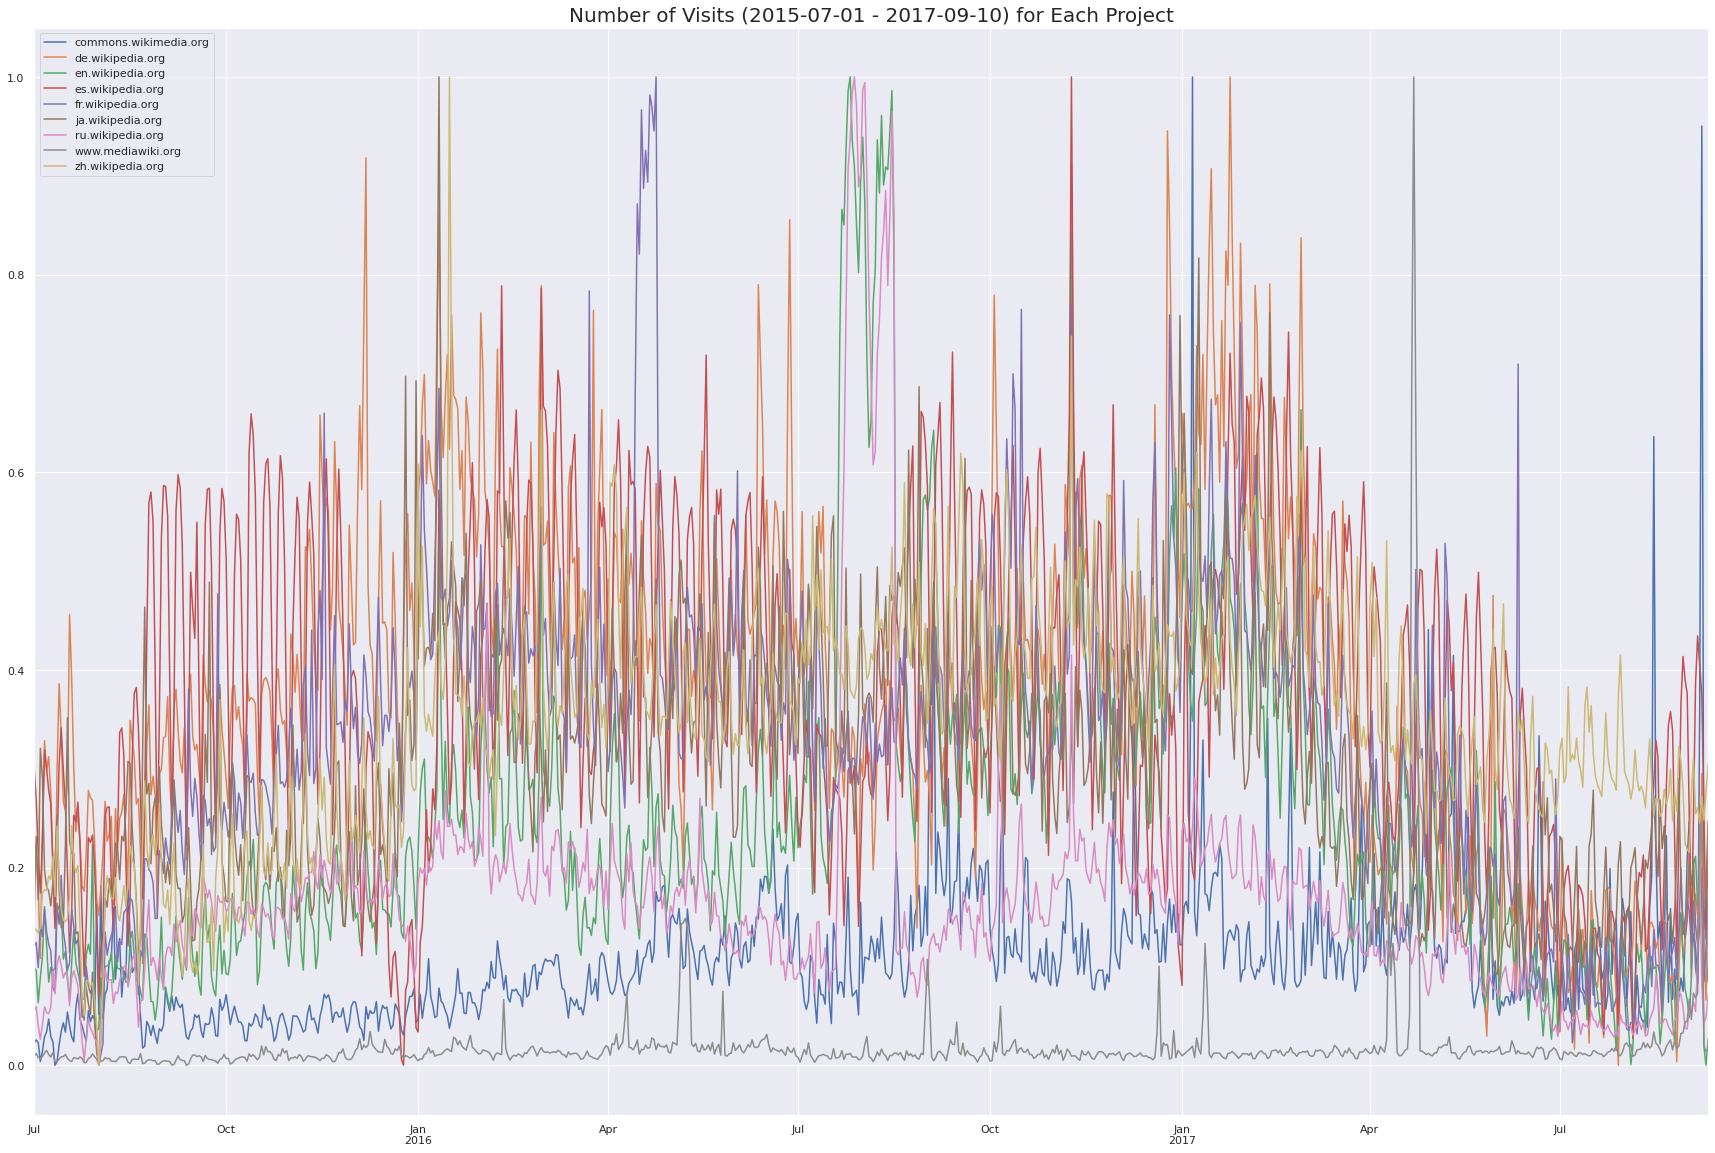

In [9]:
results_ = df_p.plot()

results_ = plt.title('Number of Visits (2015-07-01 - 2017-09-10) for Each Project', fontsize=20)

# 2. Statistical descriptive analysis

In [10]:
df_p.describe()

,commons.wikimedia.org,de.wikipedia.org,en.wikipedia.org,es.wikipedia.org,fr.wikipedia.org,ja.wikipedia.org,ru.wikipedia.org,www.mediawiki.org,zh.wikipedia.org
count,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,0.108817,0.385272,0.252438,0.379880,0.331562,0.301400,0.167958,0.019069,0.348710
std,0.076880,0.176840,0.171374,0.162154,0.158015,0.129302,0.137718,0.052880,0.117945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.063152,0.259763,0.133641,0.258999,0.232209,0.199015,0.103554,0.008698,0.273401
50%,0.096266,0.379673,0.216694,0.376587,0.336734,0.295760,0.154138,0.012109,0.353904
75%,0.133749,0.494599,0.324232,0.517963,0.425239,0.385711,0.192647,0.016052,0.425105
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


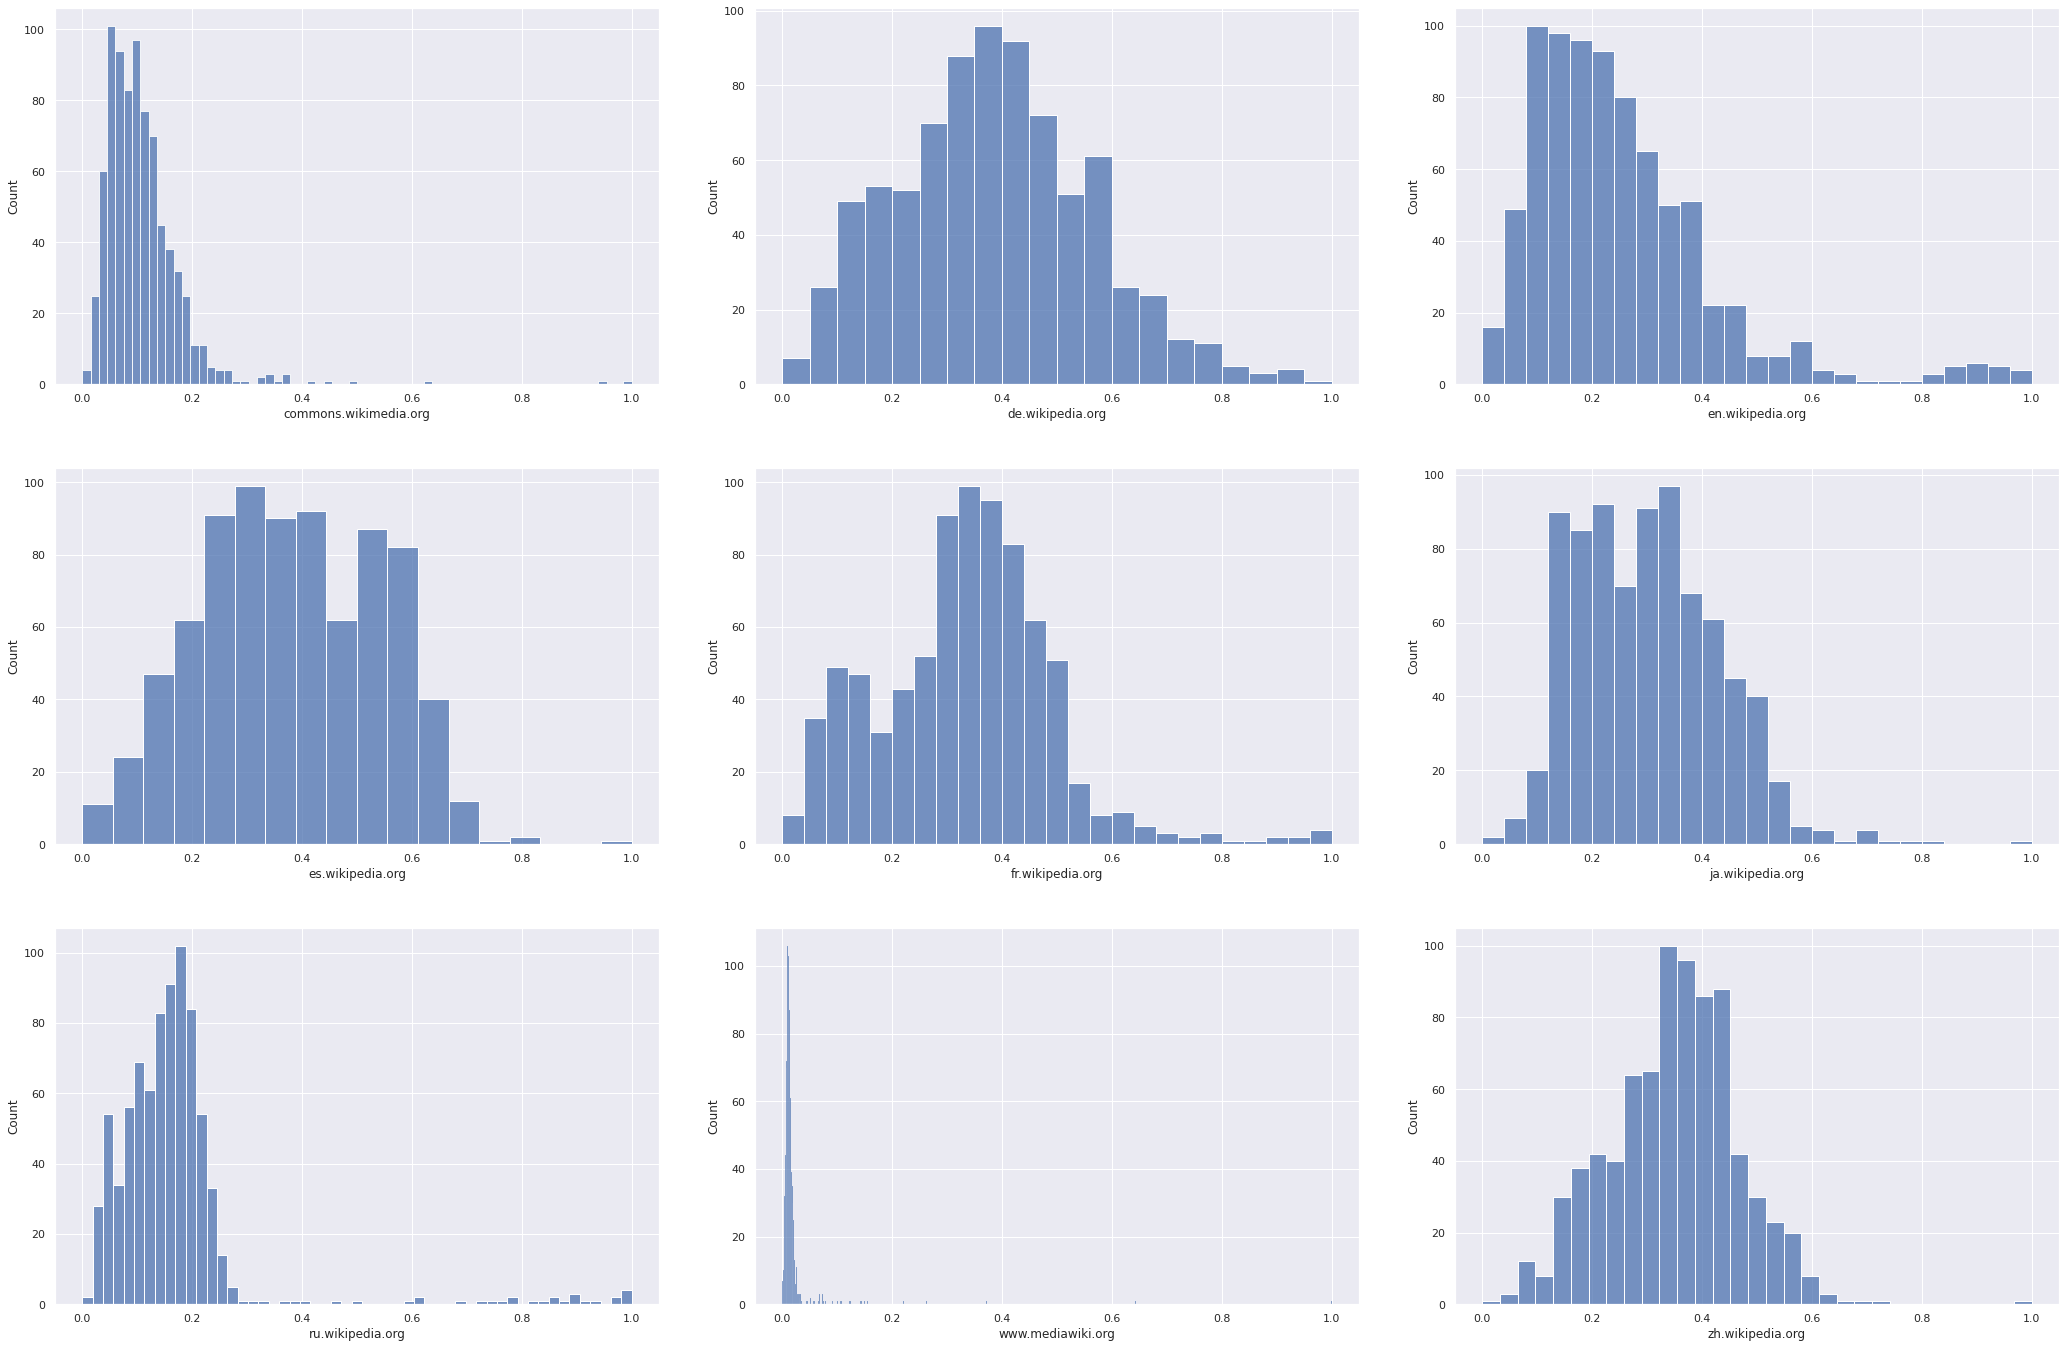

In [11]:
f, ax = plt.subplots(3, 3)
columns = df_p.columns
ax = ax.ravel()
f.tight_layout(pad=5.0)

for i in range(len(columns)):
        sns.histplot(data=df_p[columns[i]], ax=ax[i])

Above histograms for each project vary in terms of distribution properties.Some of them exhibit normal distribution.

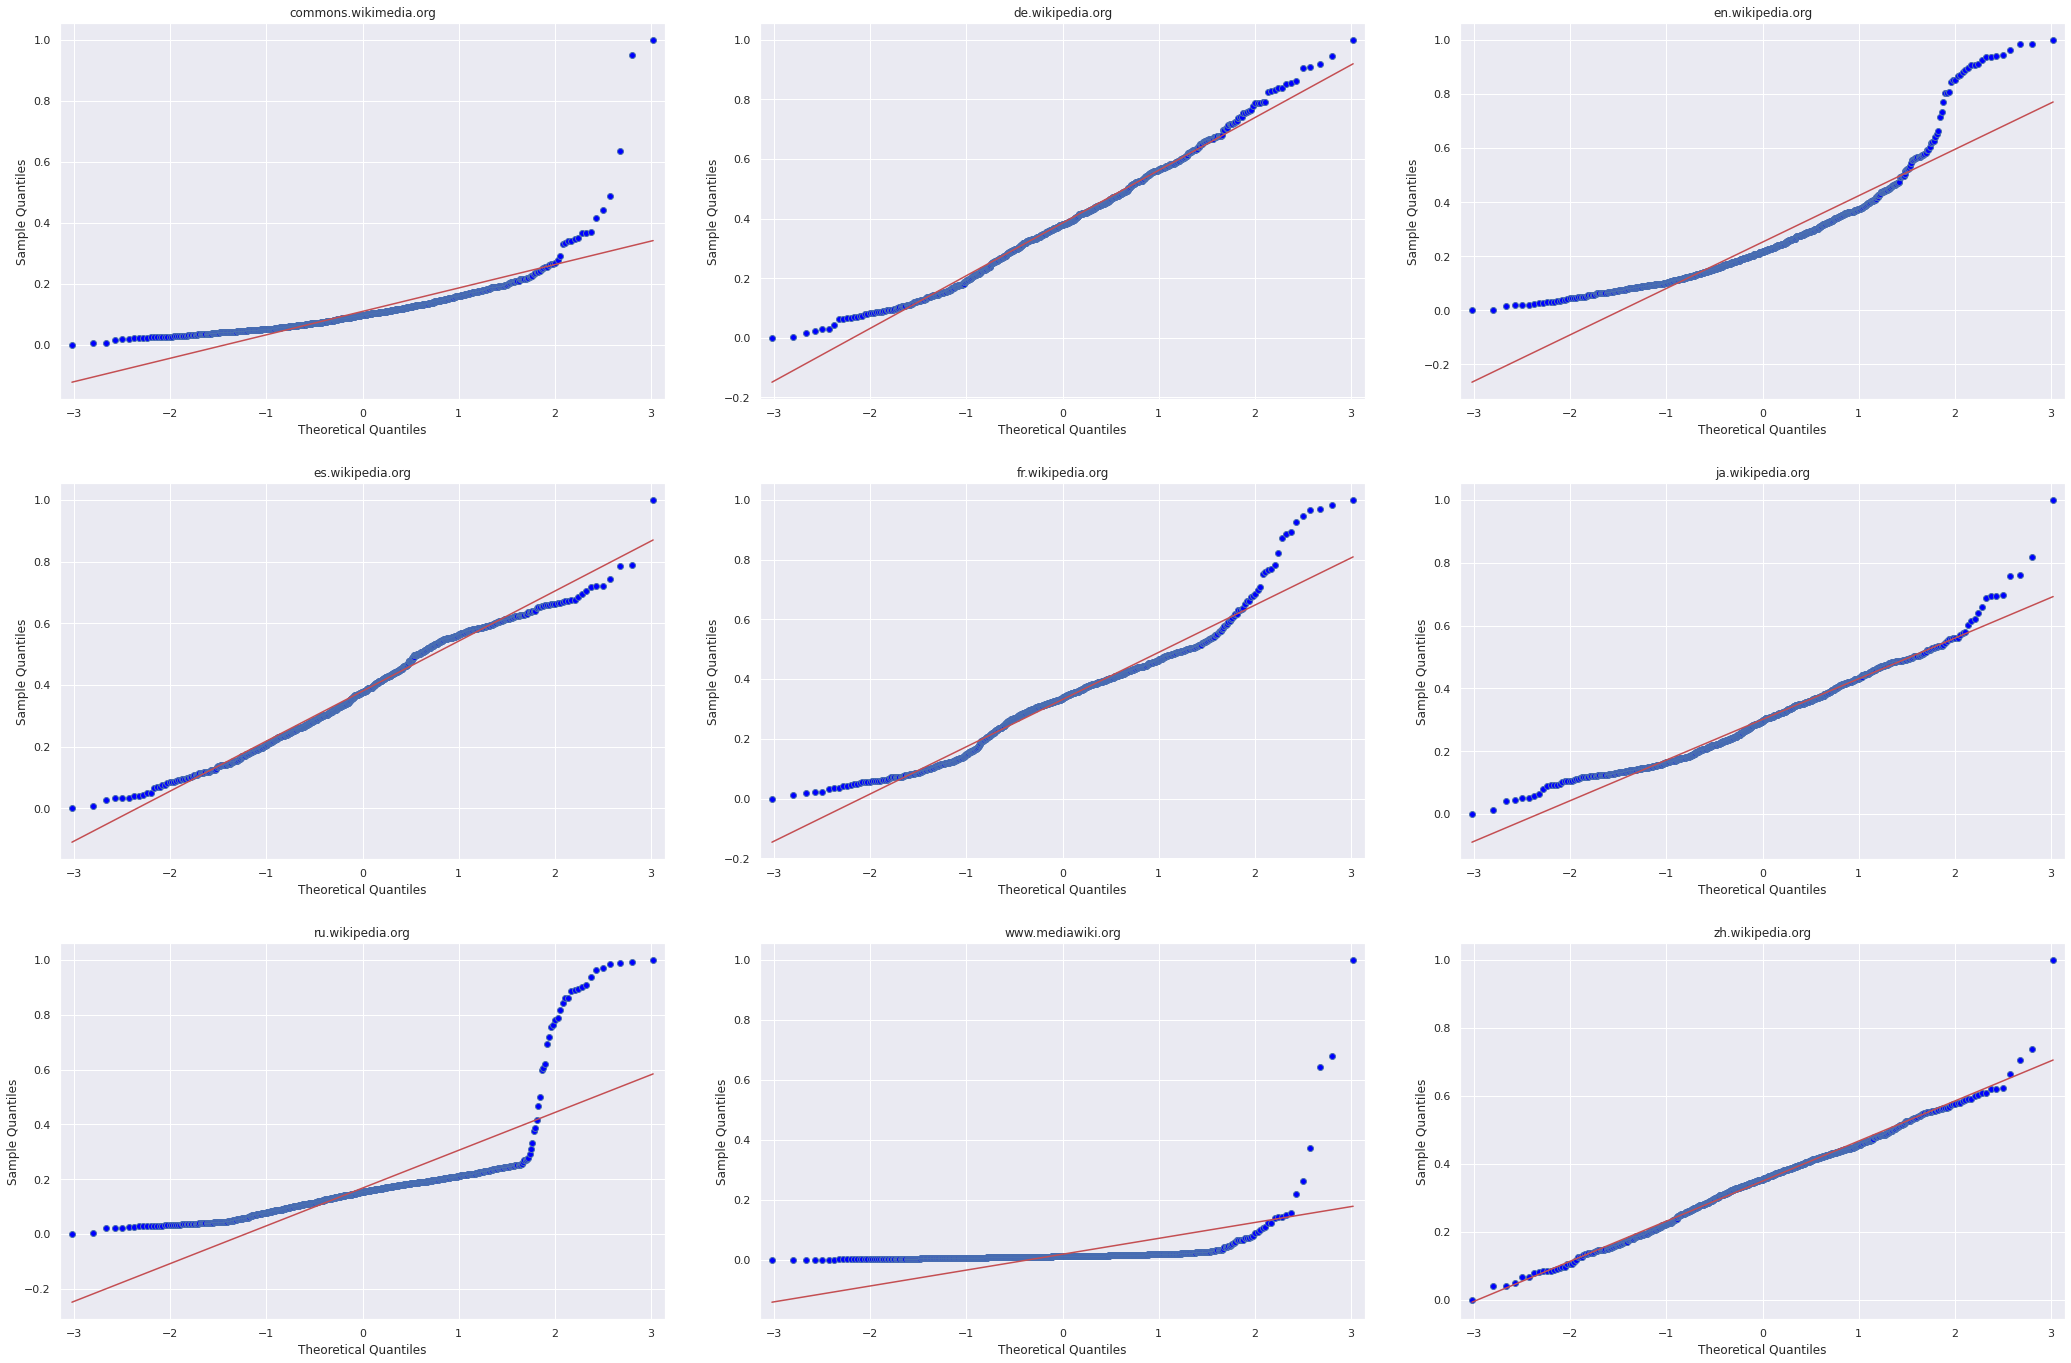

In [12]:
# check for normal distribution

from statsmodels.graphics.gofplots import qqplot
f, ax = plt.subplots(3, 3)
ax = ax.ravel()
f.tight_layout(pad=5.0)

for i in range(len(columns)):
        results_ = qqplot(data=df_p[columns[i]], ax=ax[i], line='s')
        ax[i].set_title(columns[i])

As consistent with the histograms, while some projects such as *zh.wikipedia.org, de.wikipedia.org* exhibit normal distribution, some of them does not.

In [13]:
from statsmodels.tsa.stattools import adfuller

for column in columns:
    adfuller_test = adfuller(df_p[column], autolag= "AIC")
    print("{}".format(column))
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    
    if adfuller_test[1] > 0.05:
        print("Non-Stationary")
    else:
        print("Stationary")
    print()

commons.wikimedia.org
ADF test statistic: -4.914518525664446
p-value: 3.267467393490174e-05
Stationary

de.wikipedia.org
ADF test statistic: -1.7589633506297924
p-value: 0.40101702675507633
Non-Stationary

en.wikipedia.org
ADF test statistic: -2.806398139885772
p-value: 0.05736563543418618
Non-Stationary

es.wikipedia.org
ADF test statistic: -3.659362427703231
p-value: 0.004722457121015502
Stationary

fr.wikipedia.org
ADF test statistic: -1.9774001824110203
p-value: 0.2965693872852466
Non-Stationary

ja.wikipedia.org
ADF test statistic: -2.0354721828718807
p-value: 0.27123954534605377
Non-Stationary

ru.wikipedia.org
ADF test statistic: -5.35023060023701
p-value: 4.305456204256518e-06
Stationary

www.mediawiki.org
ADF test statistic: -6.544045620208049
p-value: 9.193727965838012e-09
Stationary

zh.wikipedia.org
ADF test statistic: -1.9955893313023643
p-value: 0.2885103661246279
Non-Stationary



Since most of the Project's time series are not stationary, we can apply diff() method and check whether their trends are stationary, then seek for correlation between changes in series.

In [14]:
for column in columns:
    adfuller_test = adfuller(df_p[column].diff().dropna(), autolag= "AIC")
    print("{}".format(column))
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    
    if adfuller_test[1] > 0.05:
        print("Non-Stationary")
    else:
        print("Stationary")
    print()

commons.wikimedia.org
ADF test statistic: -9.713465574188858
p-value: 9.972503538797585e-17
Stationary

de.wikipedia.org
ADF test statistic: -6.816164318613532
p-value: 2.056610949999037e-09
Stationary

en.wikipedia.org
ADF test statistic: -5.622507046327812
p-value: 1.1366445343155552e-06
Stationary

es.wikipedia.org
ADF test statistic: -7.305815108598681
p-value: 1.3024501130474744e-10
Stationary

fr.wikipedia.org
ADF test statistic: -10.150971887792501
p-value: 7.953073146915594e-18
Stationary

ja.wikipedia.org
ADF test statistic: -9.090293603053638
p-value: 3.840553873267335e-15
Stationary

ru.wikipedia.org
ADF test statistic: -22.473981997421212
p-value: 0.0
Stationary

www.mediawiki.org
ADF test statistic: -12.369925146184567
p-value: 5.309631725932675e-23
Stationary

zh.wikipedia.org
ADF test statistic: -8.047897359444786
p-value: 1.7741227926842595e-12
Stationary



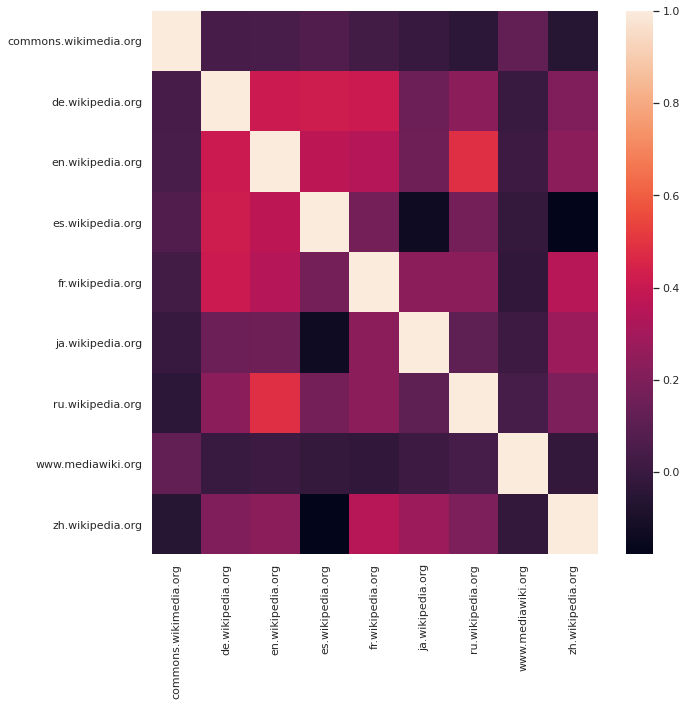

In [15]:
# Pearson correlation between derivatives of time series 
df_diff = pd.DataFrame()
for column in columns:
    df_diff[column] = df_p[column].diff().dropna()

correlations = df_diff.corr()

plt.figure(figsize=(10,10))
reults_ = sns.heatmap(correlations)

A more convenient way for checking co-integration is the Johansen's Test which may be applied on non-stationary data sets. It shows that even though time series are not stationary, if their changes in time correlate with each other, they are considered as cointegrated.

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
res = coint_johansen(df_p,-1,1)

print("Trace statistics: {}".format(res.lr1))
print()
print("Critical values [90%, 95%, 99%]:\n\n{}".format(res.cvt))

Trace statistics: [967.78633802 725.79445255 508.16507442 332.45651602 202.7276932
 113.29673331  54.29322047  23.07812543   1.22646314]

Critical values [90%, 95%, 99%]:

[[173.2292 179.5199 191.8122]
 [137.9954 143.6691 154.7977]
 [106.7351 111.7797 121.7375]
 [ 79.5329  83.9383  92.7136]
 [ 56.2839  60.0627  67.6367]
 [ 37.0339  40.1749  46.5716]
 [ 21.7781  24.2761  29.5147]
 [ 10.4741  12.3212  16.364 ]
 [  2.9762   4.1296   6.9406]]


Since the trace results for 8 / 9 of the series fall into the confidence interval (except zh.wikipedia.org) we can say that the projects' time series are conintegrated.

# 3. Feature Engineering

For time series, date-time features (timestamps), lag features (prior time steps) and window features (fixed window of prior time steps) can be created. These features are particularly important while using ml clustering and decision tree algorithms. We can add seasonal and weekend effects.

In [17]:
df_p['quarter'] = df_p.index.quarter
df_p['weekday'] = df_p.index.weekday
df_p['weekend'] = df_p['weekday'].isin([5, 6]).map(int)

In [18]:
df_p.head()

,commons.wikimedia.org,de.wikipedia.org,en.wikipedia.org,es.wikipedia.org,fr.wikipedia.org,ja.wikipedia.org,ru.wikipedia.org,www.mediawiki.org,zh.wikipedia.org,quarter,weekday,weekend
2015-07-01,0.022128,0.227120,0.098296,0.302148,0.120009,0.145971,0.054885,0.009537,0.136774,3,2,0
2015-07-02,0.025718,0.214765,0.096193,0.269748,0.124234,0.231457,0.059298,0.011818,0.137563,3,3,0
2015-07-03,0.023064,0.178795,0.063377,0.213637,0.098807,0.167478,0.040323,0.007926,0.134057,3,4,0
2015-07-04,0.003894,0.108089,0.088699,0.174373,0.142658,0.320730,0.026034,0.006787,0.139125,3,5,1
2015-07-05,0.014162,0.236138,0.109717,0.227157,0.130264,0.290135,0.040729,0.008783,0.174511,3,6,1


# 4. Modelling

## 4.1 VAR (Vector Auto Regression)

In order to apply VAR model, which is a common statistical approach for multivariate time series, ts should be stationary, and have a cross correlation between time series. Since the levels are not stationary, we use first derivatives previously checked with the ADF test and observed as stationary.

In [19]:
# prediction time window (eg. last 20 days of the data)
PREDICTED_DAYS = 20

#creating the train and validation set
columns = ['commons.wikimedia.org', 'de.wikipedia.org', 'en.wikipedia.org', 'es.wikipedia.org',
           'fr.wikipedia.org', 'ja.wikipedia.org','ru.wikipedia.org', 'www.mediawiki.org', 'zh.wikipedia.org']

train = df_p[columns].diff().dropna()[:-PREDICTED_DAYS].values
valid = df_p[columns].diff().dropna()[-PREDICTED_DAYS:].values

#fit the model

from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)
model_fit = model.fit(10) #lag parameter

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/home/cansub/miniconda3/lib/python3.8/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


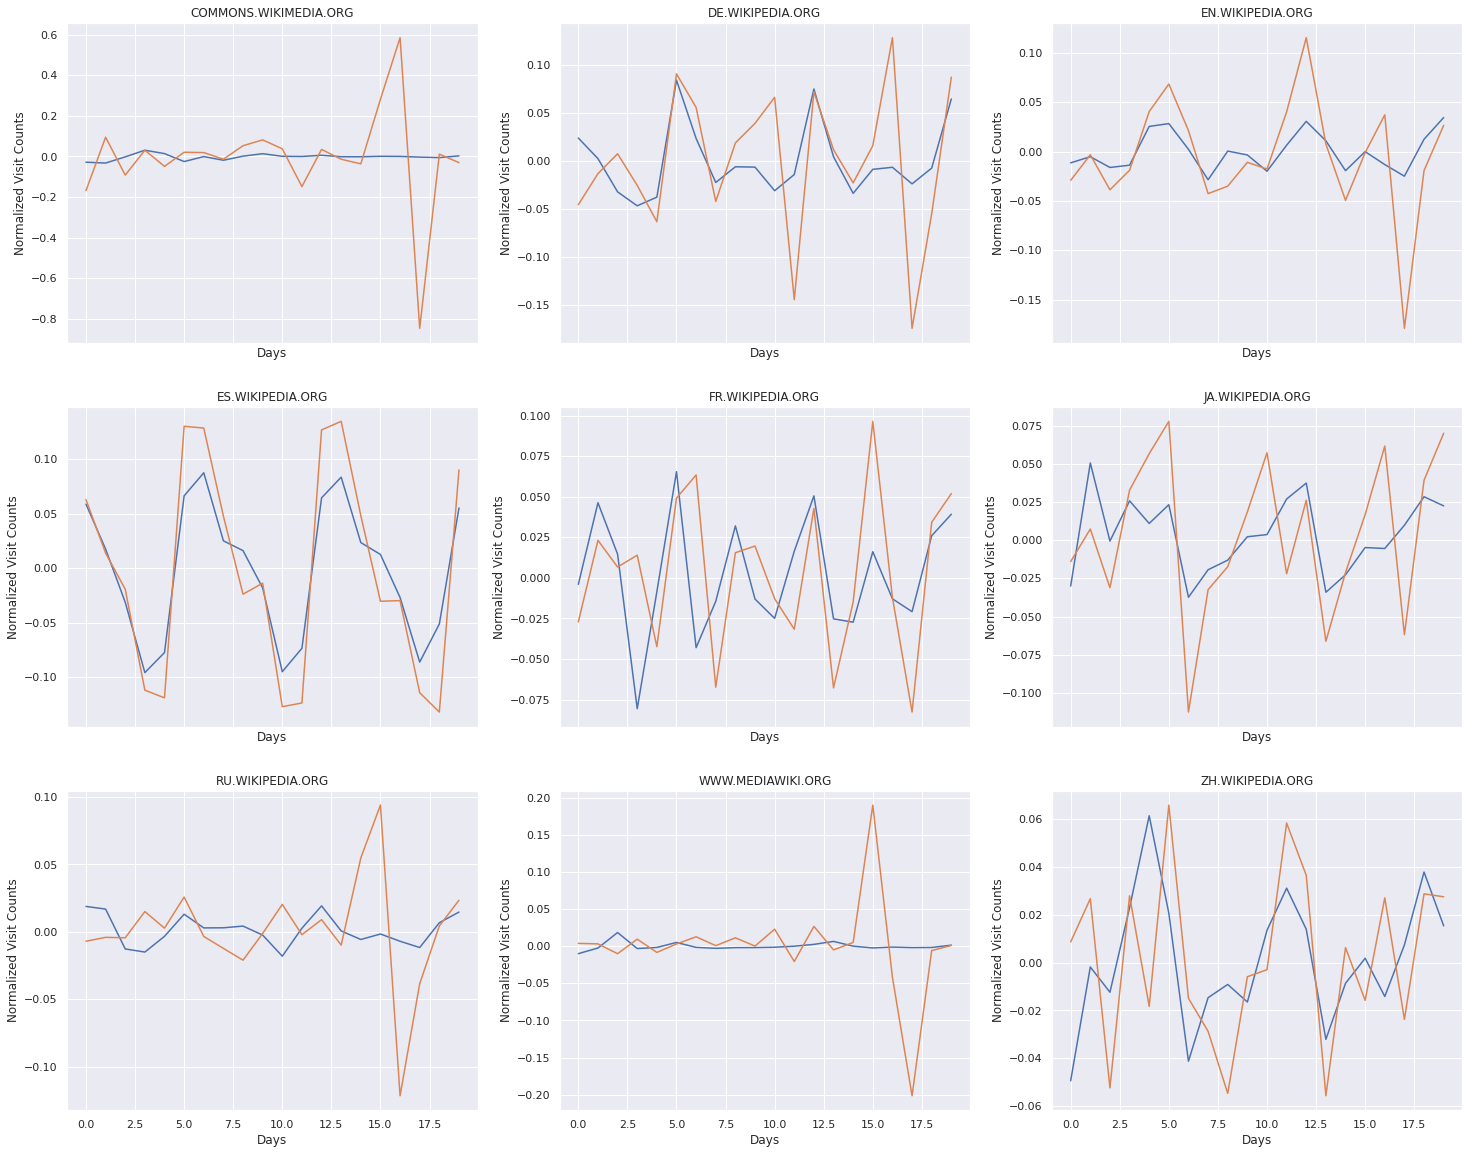

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(25,20))

for idx, (pred, gt, col) in enumerate(zip(prediction.T, valid.T, columns)):
    j = idx % 3
    if idx % 3 == 0:
        i = int(idx / 3)
    axes[i, j].set_title(col.upper())
    axes[i, j].set_xlabel('Days')
    axes[i, j].set_ylabel('Normalized Visit Counts')
    axes[i][j].plot(pred)
    axes[i][j].plot(gt)

In general the results are quite satisfactory, but the model seems not to be able to forcast larger fluctuations in the number of visits correctly.

An interesting observation is that, the forcasts for the domains `commons.wikimedia.org`, `www.mediawiki.org` and `ru.wikipedia.org` match the real values poorly, which could be expected as their statistics highly deviate from normal distribution.